### UNet

U-Net is a widely used deep learning architecture that was first introduced in the “U-Net: Convolutional Networks for Biomedical Image Segmentation” paper. The primary purpose of this architecture was to address the challenge of limited annotated data in the medical field. This network was designed to effectively leverage a smaller amount of data while maintaining speed and accuracy. The architecture is known for its U-shaped structure, which enables it to capture both context and fine details, making it highly effective for segmentation tasks.

#### UNet architecture

The U-Net architecture consists of two main parts: the contracting path (encoder) and the expansive path (decoder). These parts are connected by a bottleneck, and skip connections link corresponding layers in the encoder and decoder, enabling the network to combine spatial and contextual information effectively. The contracting path contains encoder layers that capture contextual information and reduce the spatial resolution of the input, while the expansive path contains decoder layers that decode the encoded data and use the information from the contracting path via skip connections to generate a segmentation map.

**1. Contracting Path (Encoder):** <br/>
The contracting path follows the typical architecture of a convolutional neural network. It consists of several layers of convolution and pooling operations, which progressively reduce the spatial dimensions and increase the number of feature channels. This part of the network captures the context and high-level features of the input image. Capturing the context of an image means understanding the broader, high-level information present in the image, such as objects, patterns, and relationships between different parts of the image. In image segmentation, capturing context is crucial because it helps the model recognize and distinguish different objects and their boundaries.

In the U-Net architecture, the encoder captures context through a series of convolutional and pooling layers. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. Here’s a detailed look at how it works:

1. Initial Convolutional Layers: 
    - The first convolutional layer applies a set of filters to the input image to extract basic features. For example, a 3x3 filter might detect edges in different orientations.
    - The output of this layer is passed through a ReLU activation function and then through another convolutional layer to extract more complex features.
2. First Pooling Layer:
    - The first pooling layer down-samples the feature maps, reducing their spatial dimensions. This operation helps in reducing computational complexity and captures broader context by summarizing the features in each pooling window.
3. Subsequent Convolutional and Pooling Layers: 
    - Each subsequent block consists of more convolutional layers followed by pooling. As we go deeper, the feature maps become more abstract and capture higher-level features. For example, in a later layer, the network might recognize patterns corresponding to parts of objects or even entire objects, rather than just simple edges or textures.
4. Bottleneck: 
    - The bottleneck layer is the transition between the encoder and decoder. It consists of two convolutional layers with ReLU activation and one max-pooling layer. This layer captures the most compressed representation of the input image with a large receptive field that encompasses the entire input image. This layer aggregates the global context and high-level features before passing them to the decoder. The receptive field refers to the region of the input image that affects a particular output neuron. As we move deeper into the network, the receptive field of neurons increases, meaning each neuron in deeper layers can "see" a larger portion of the input image.

**2. Expansive Path (Decoder):**
The expansive path consists of a series of upsampling and convolutional layers. It gradually increases the spatial dimensions and reduces the number of feature channels, reconstructing the image while maintaining the details.

- Upsampling Layers: Each upsampling layer (transpose convolution) upsamples the image or feature map (spatial) dimensions and is followed by a convolutional layer, which doubles the number of channels.
- Skip Connections: The feature maps from the corresponding layers in the encoder are concatenated with the upsampled feature maps in the decoder. This helps the network retain fine-grained details.

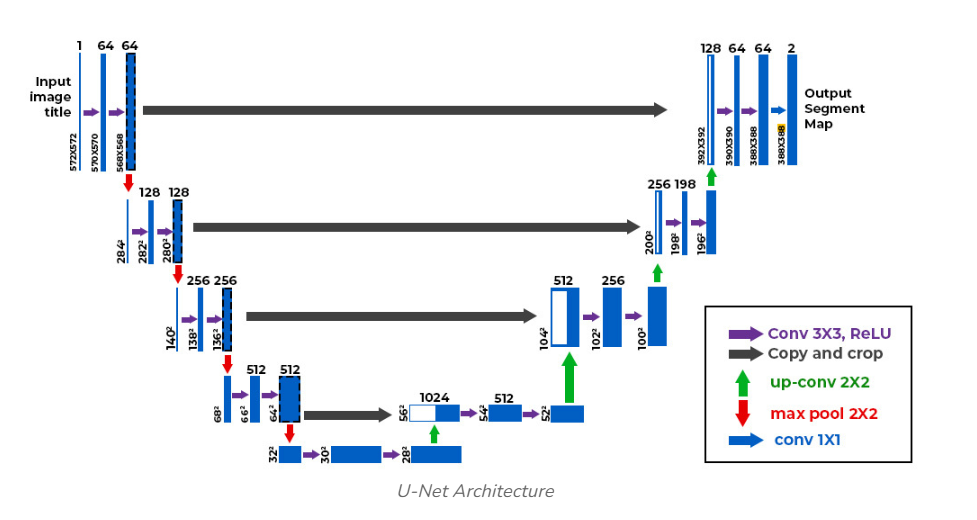

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# n_out = ((n + 2p -f)/s) + 1 where n = input image (square) dimension, n_out = output image dimension, f = kernel size
# p = padding, s = stride
# For transpose convolution n_out = (n-1)*s-2p+f+p_out where 
# where 
# s is the stride of the transposed convolution
# p is the padding of the transposed convolution
# f is the size of the transposed convolution kernel
# p_out is the additional padding added to the output

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            self.conv_block(in_channels, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_block(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_block(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_block(256, 512),
            # bottleneck with one MaxPool and followed by 2 conv layers
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_block(512, 1024)
        )

        self.decoder = nn.Sequential(
            self.upconv_block(1024, 512),
            self.upconv_block(512, 256),
            self.upconv_block(256, 128),
            self.upconv_block(128, 64)
        )

        # Final conv 1x1 layer the outputs number of channels = number of segmentation classes
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    # input image size x = (512, 512), input_channels = 1
    def forward(self, x):
        # Encoding
        enc1 = self.conv_block(1, 64)(x)    # enc1 = (B, 64, 512, 512)
        # encoder[1] is the first MaxPool layer
        enc2 = self.encoder[1](enc1)    # enc2 = (B, 64, 256, 256)
        # encoder[2] is the second conv_block with input channels = 64 and output channels = 128
        enc3 = self.encoder[2](enc2)    # enc3 = (B, 128, 256, 256)
        # encoder[3] is the second MaxPool layer
        enc4 = self.encoder[3](enc3)    # enc4 = (B, 128, 128, 128)
        # encoder[4] is the third conv_block with input_channels = 128 and output_channels = 256
        enc5 = self.encoder[4](enc4)    # enc5 = (B, 256, 128, 128)
        # encoder[5] is the third MaxPool layer
        enc6 = self.encoder[5](enc5)    # enc6 = (B, 256, 64, 64)
        # encoder[6] is the fourth conv_block with input_channels = 256 and output_channels = 512
        enc7 = self.encoder[6](enc6)    # enc7 = (B, 512, 64, 64)
        # Bottleneck starts here with one MaxPool followed to 2 conv layers
        # encoder[7] is the fourth MaxPool layer
        enc8 = self.encoder[7](enc7)    # enc8 = (B, 512, 32, 32)
        # encoder[8] is the fifth conv_block with input_channels = 512 and output_channels = 1024
        bottleneck = self.encoder[8](enc8)    # enc9 = (B, 1024, 32, 32)        

        # Decoding with skip connections
        dec1 = self.decoder[0][0](bottleneck)
        # f=2, s=2, p=0, p_out=0, n_out = (n-1)*s-2p+f+p_out = (32-1)*2-0+2+0 = 64, in_channels=1024, out_channels=512
        # dec1 = (B, 512, 64, 64) output from first transpose convolution
        # skip connection from encoder 
        dec1 = torch.cat((enc7, dec1), dim=1)   # dec1 = (B, 1024, 64, 64)
        # concatenated feature map is passed to the convolution layers in the first decoder(upconv) block
        dec1 = self.decoder[0][1](dec1) # dec1 = (B, 512, 64, 64)        

        # second transpose convolution
        dec2 = self.decoder[1][0](dec1) # dec2 = (B, 256, 128, 128)
        dec2 = torch.cat((enc5, dec2), dim=1)   # dec2 = (B, 512, 128, 128)
        dec2 = self.decoder[1][1](dec2)  # dec2 = (B, 256, 128, 128)

        # third transpose convolution
        dec3 = self.decoder[2][0](dec2)    # dec3 = (B, 128, 256, 256)
        # skip connection
        dec3 = torch.cat((enc2, dec3), dim=1)   # dec3 = (B, 256, 256, 256)
        # convolution 
        dec3 = self.decoder[2][1](dec3) # dec3 = (B, 128, 256, 256)

        # fourth transpose convolution
        dec4 = self.decoder[3][0](dec3)    # dec4 = (B, 64, 512, 512)
        dec4 = torch.cat((enc1, dec4), dim=1)   # dec4 = (B, 128, 512, 512)
        dec4 = self.decoder[3][1](dec4)     # dec4 = (B, 64, 512, 512)

        # Output
        return self.final_conv(dec4)

# Example usage
model = UNet(in_channels=1, out_channels=2)
print(model)


UNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_